# 杭州萧山区项目
## 本地排放清单与MEIC比较
## `Compare local emis with MEIC`

---
*@author: Evan*\
*@date: 2023-07-20*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader

from cnmaps import get_adm_maps, clip_quiver_by_map, clip_contours_by_map, draw_map, clip_pcolormesh_by_map
import geopandas as gpd
from shapely.ops import unary_union

import sys
sys.path.append('../../src/')
from namelist import *
import findpoint as fp
from plotfunctions import *

In [2]:
ind = xr.open_dataset(local_ind_file)
pow = xr.open_dataset(local_pow_file)
tra = xr.open_dataset(local_tra_file)
res = xr.open_dataset(local_res_file)
agr = xr.open_dataset(local_agr_file)
local = ind + pow + tra + res + agr
local

<xarray.Dataset>
Dimensions:    (y: 138, x: 135)
Coordinates:
    longitude  (y, x) float32 117.9 117.9 117.9 118.0 ... 122.3 122.3 122.4
    latitude   (y, x) float32 28.29 28.29 28.29 28.29 ... 31.89 31.89 31.89
Dimensions without coordinates: y, x
Data variables:
    SO2        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NOx        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CO         (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PM10       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    PM25       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    VOCs       (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NH3        (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    BC         (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    OC         (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [3]:
ind = xr.open_dataset(meic_ind_file)
pow = xr.open_dataset(meic_pow_file)
tra = xr.open_dataset(meic_tra_file)
res = xr.open_dataset(meic_res_file)
agr = xr.open_dataset(meic_agr_file)
meic = ind + pow + tra + res + agr
meic

<xarray.Dataset>
Dimensions:  (TSTEP: 12, VAR: 74, DATE-TIME: 2, LAY: 1, ROW: 138, COL: 135)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables: (12/75)
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 10050005 0 ... 10050005 550000
    NO2      (TSTEP, LAY, ROW, COL) float32 0.02437 0.0102 0.0008443 ... 0.0 0.0
    NO       (TSTEP, LAY, ROW, COL) float32 0.3495 0.1462 0.01211 ... 0.0 0.0
    HONO     (TSTEP, LAY, ROW, COL) float32 0.0009362 0.0003916 ... 0.0 0.0
    CO       (TSTEP, LAY, ROW, COL) float32 4.089 1.711 0.1417 ... 0.0 0.0 0.0
    SO2      (TSTEP, LAY, ROW, COL) float32 0.1029 0.04306 0.003566 ... 0.0 0.0
    ...       ...
    PMN      (TSTEP, LAY, ROW, COL) float32 0.002071 0.0008662 ... 0.0 0.0
    PH2O     (TSTEP, LAY, ROW, COL) float32 0.04105 0.01717 0.001422 ... 0.0 0.0
    PMOTHR   (TSTEP, LAY, ROW, COL) float32 2.102 0.8792 0.07281 ... 0.0 0.0 0.0
    PMC      (TSTEP, LAY, ROW, COL) float32 1.793 0.7501 0.06212 ... 0.0 0.0 0.0
    HCL      (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CL2      (TSTEP, LAY, ROW, COL) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [4]:
zhejiang = get_adm_maps(province='浙江省', record='first', only_polygon=True)
hangzhou  = get_adm_maps(city='杭州市', record='first', only_polygon=True)
xiaoshan = get_adm_maps(district='萧山区', record='first', only_polygon=True)

In [5]:
lon = local.longitude
lat = local.latitude

shp = gpd.read_file('D:/data/Project_Xiaoshan/shapefile/Xiaoshan_Buffer/Xiaoshan_Buffer.shp')
mask = polygon_to_mask(shp.geometry[0],lon,lat)
mask_da = xr.DataArray(mask,dims=('ROW','COL'))

In [6]:
using_extent=[120.,120.7,29.8,30.32]
using_sec='All Sectors'

## NOx

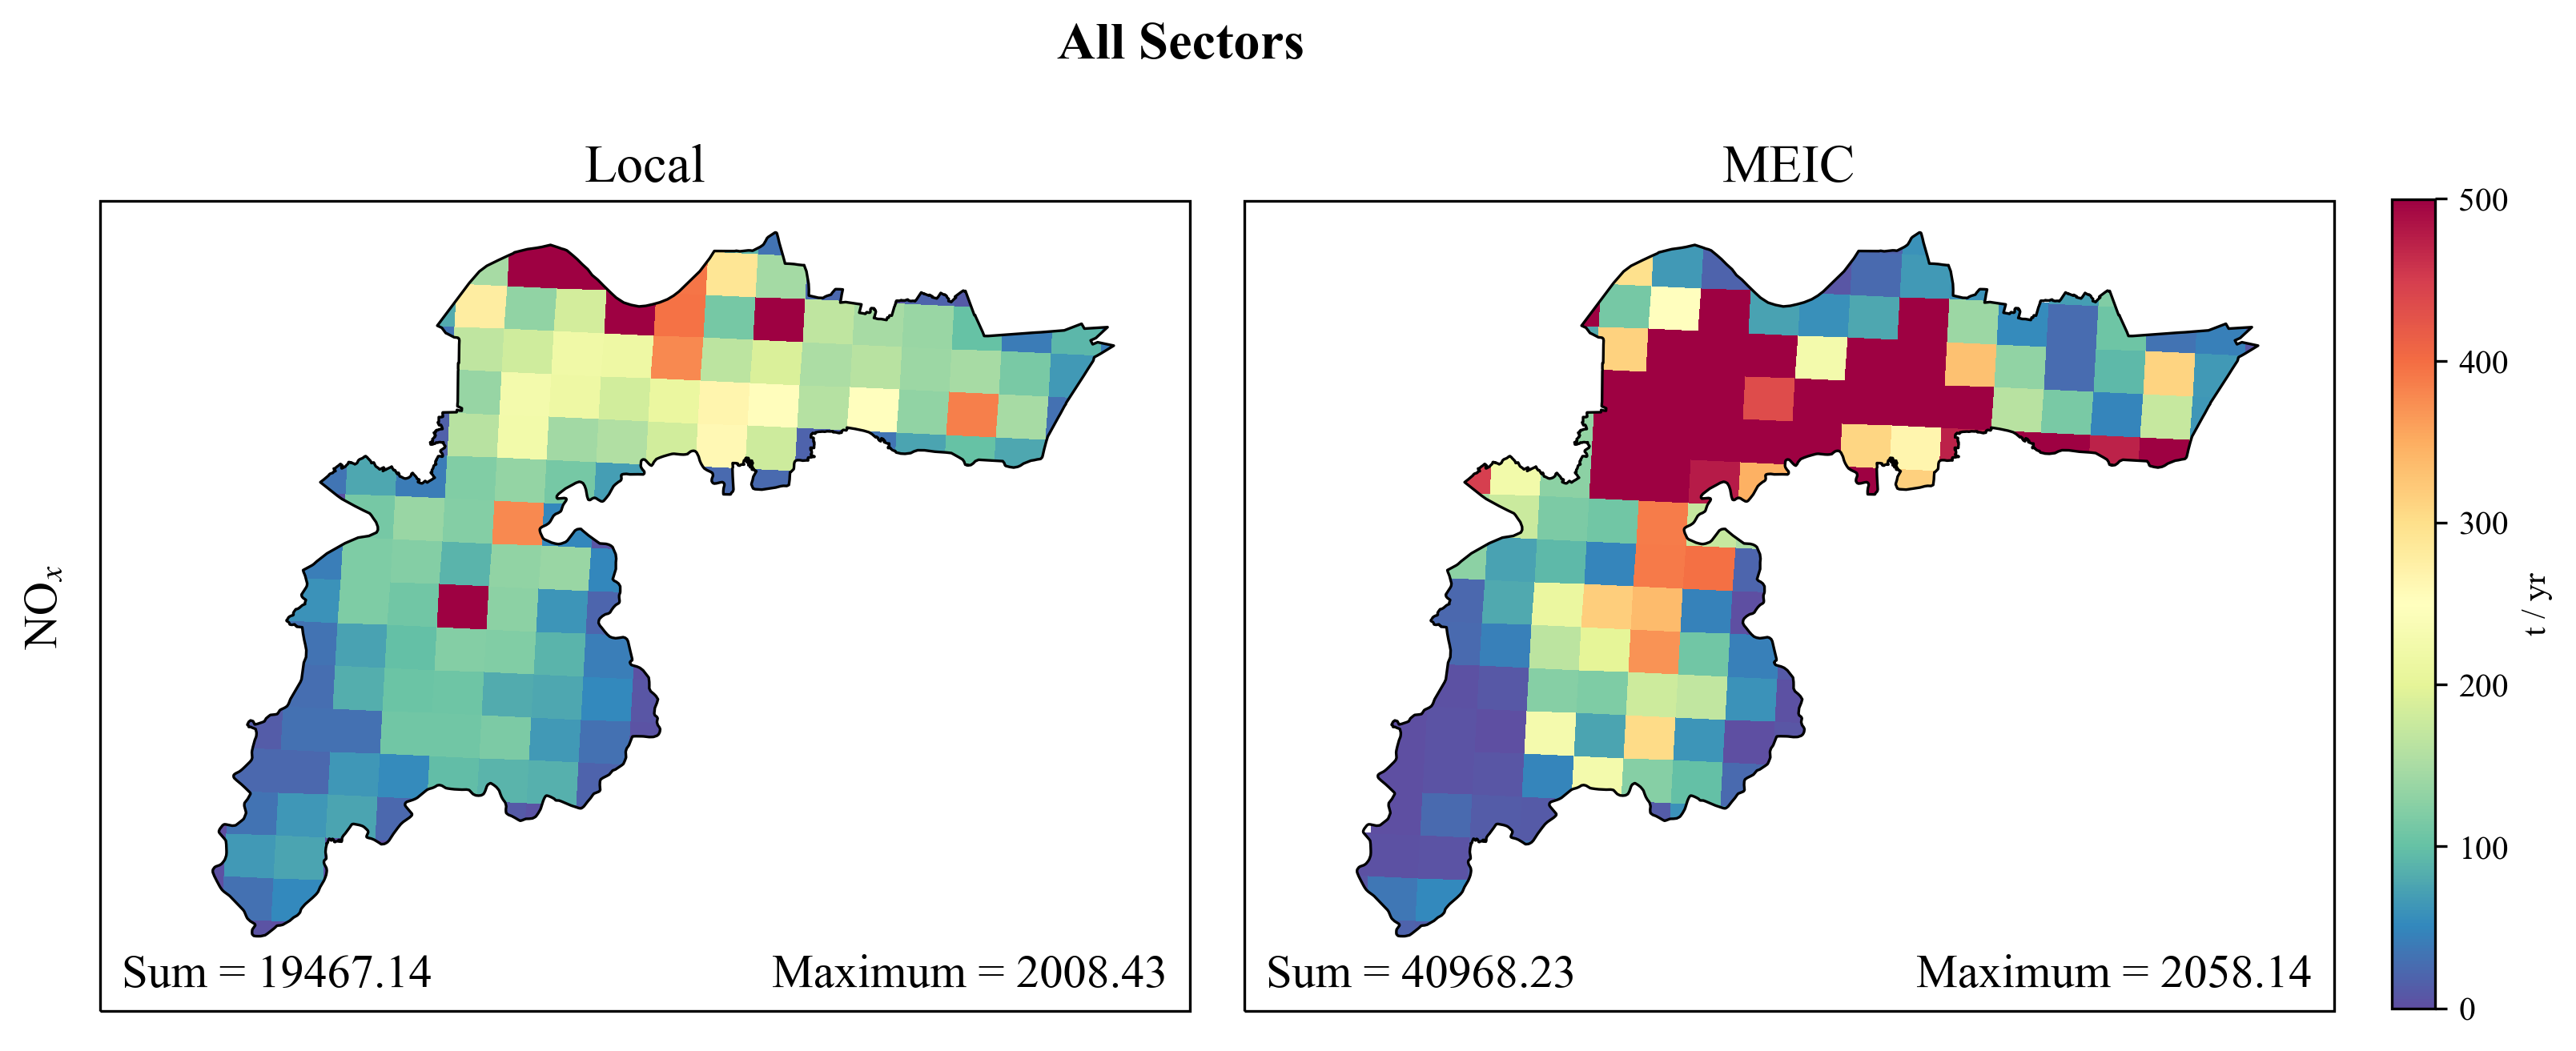

In [7]:
cmin   = 0
cmax   = 500
clevel = 100

# data from local emis
data_local = local.NOx.squeeze()

# data from meic emis
NO = meic.NO.sum(dim='TSTEP').squeeze()
NO_xs = NO.where(mask_da)
NO2 = meic.NO2.sum(dim='TSTEP').squeeze()
NO2_xs = NO2.where(mask_da)
data_meic = (NO_xs*30 + NO2_xs*46)

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='NO$_x$')

## SO2

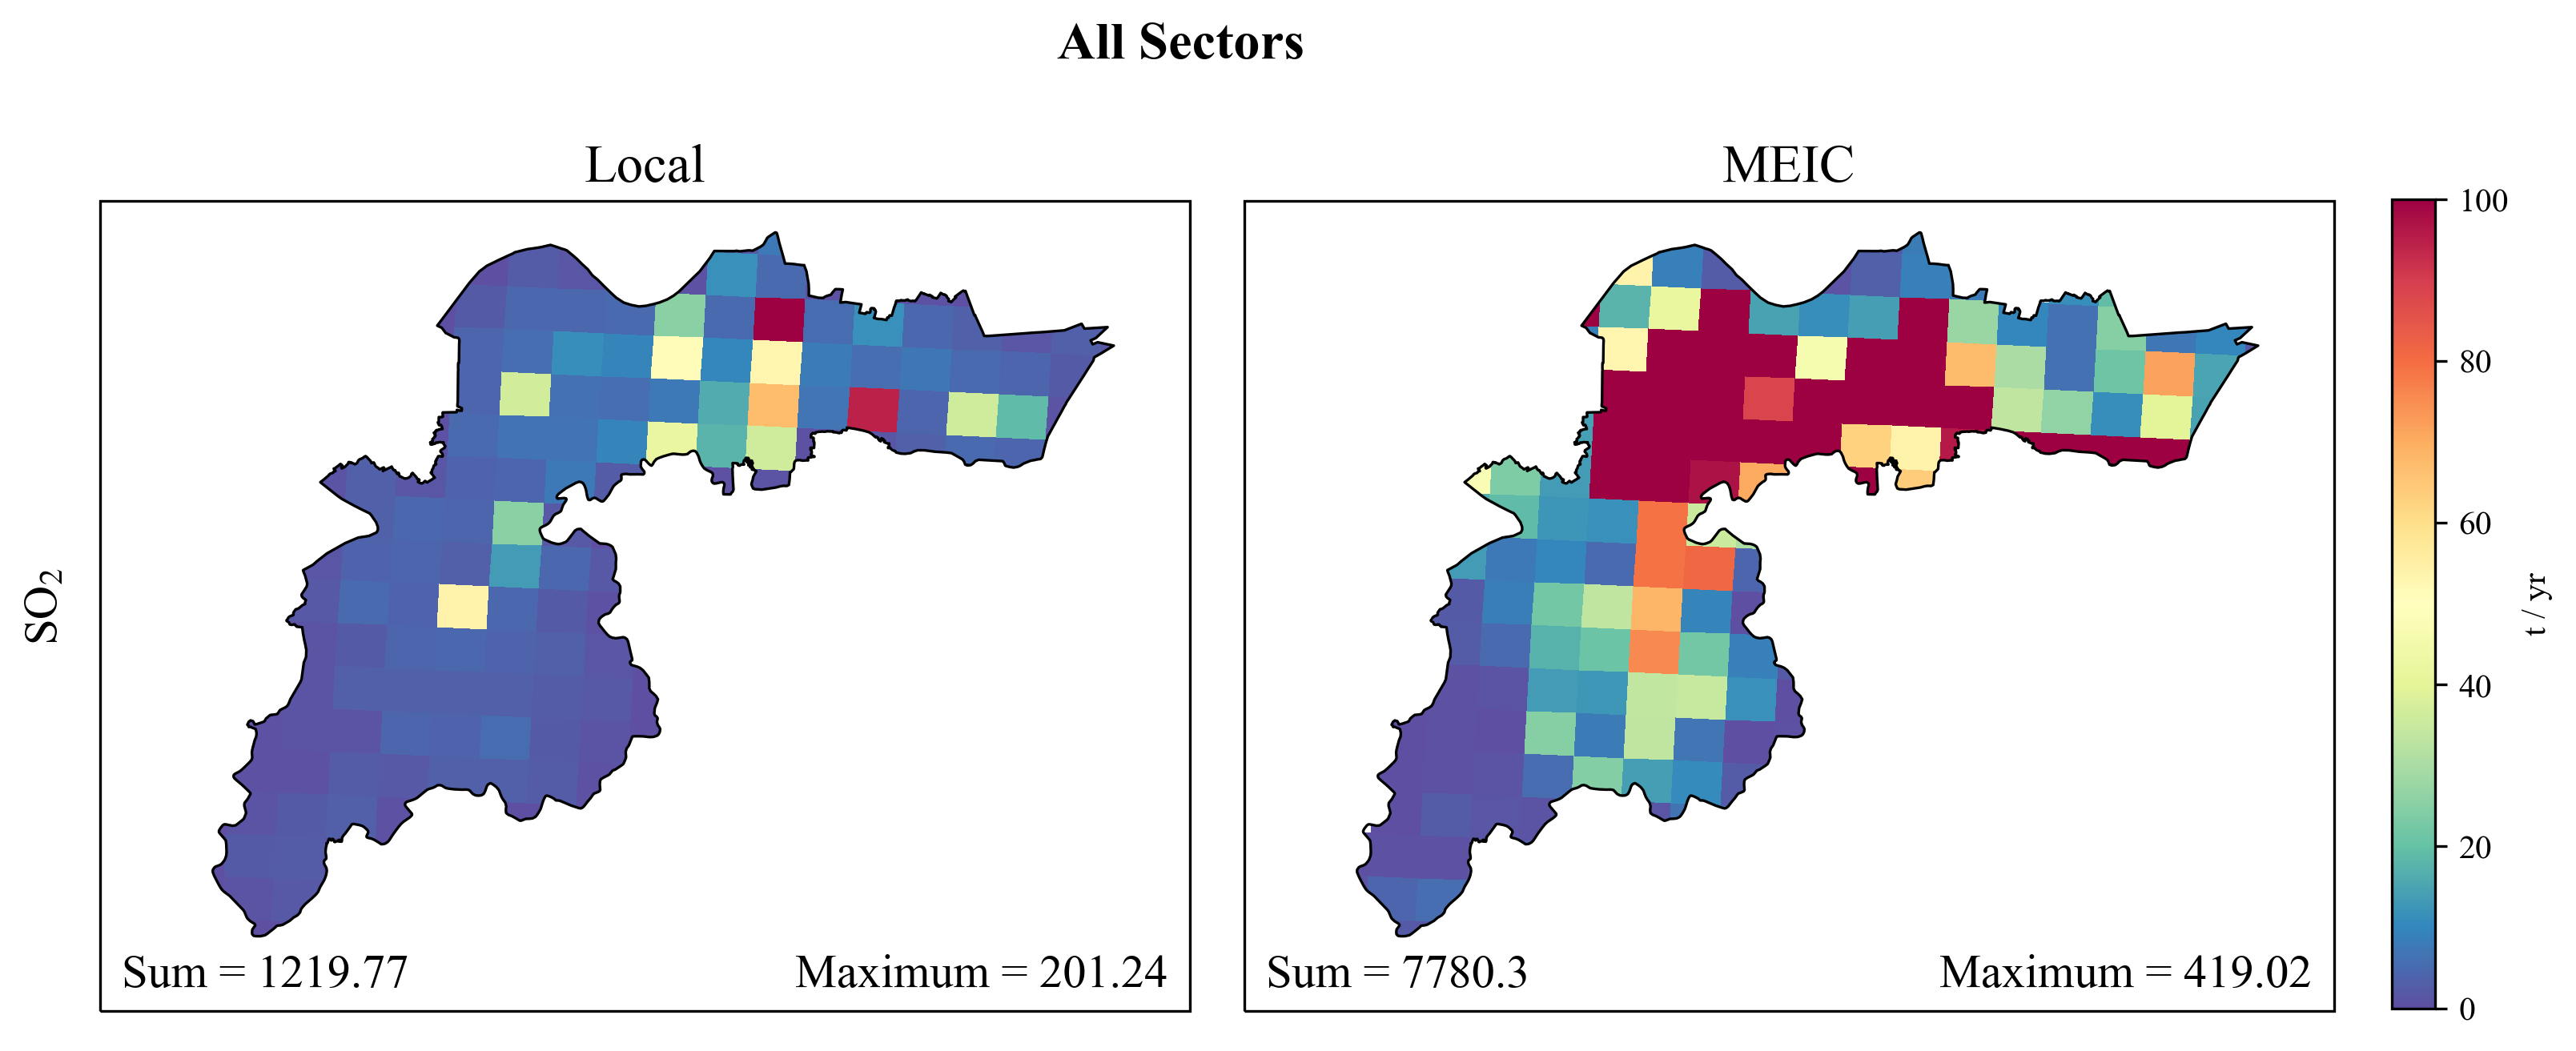

In [30]:
cmin   = 0
cmax   = 100
clevel = 20

# data from local emis
data_local = local.SO2.squeeze()

# data from meic emis
SO2 = meic.SO2.sum(dim='TSTEP').squeeze()
SO2_xs = SO2.where(mask_da)
data_meic = (SO2_xs*64)

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='SO$_2$')

## CO

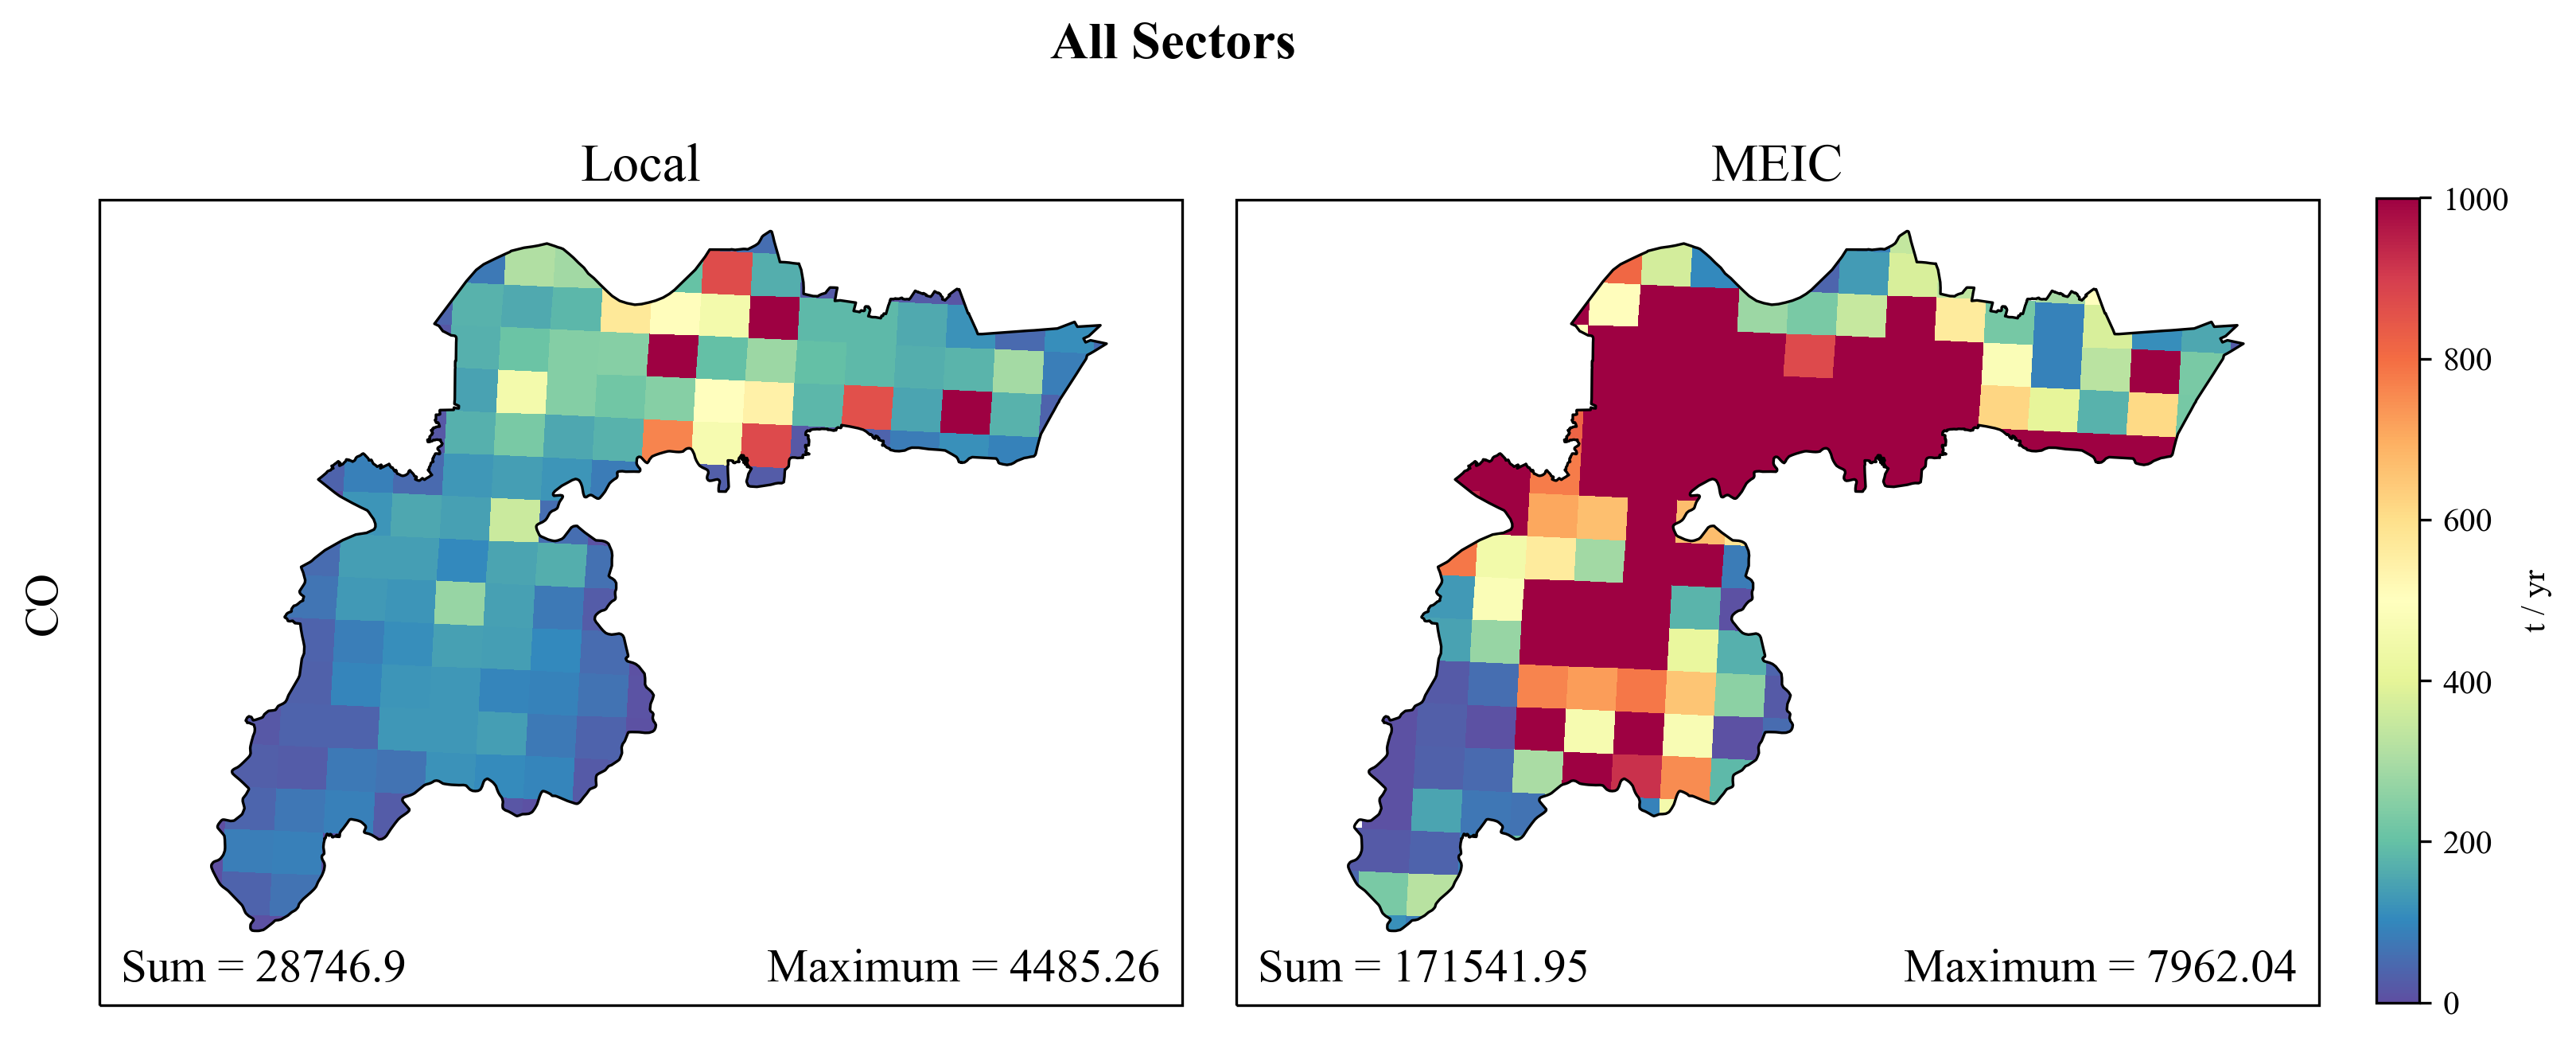

In [8]:
cmin   = 0
cmax   = 1000
clevel = 200

# data from local emis
data_local = local.CO.squeeze()

# data from meic emis
CO = meic.CO.sum(dim='TSTEP').squeeze()
CO_xs = CO.where(mask_da)
data_meic = (CO_xs*28)

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='CO')

## NH3

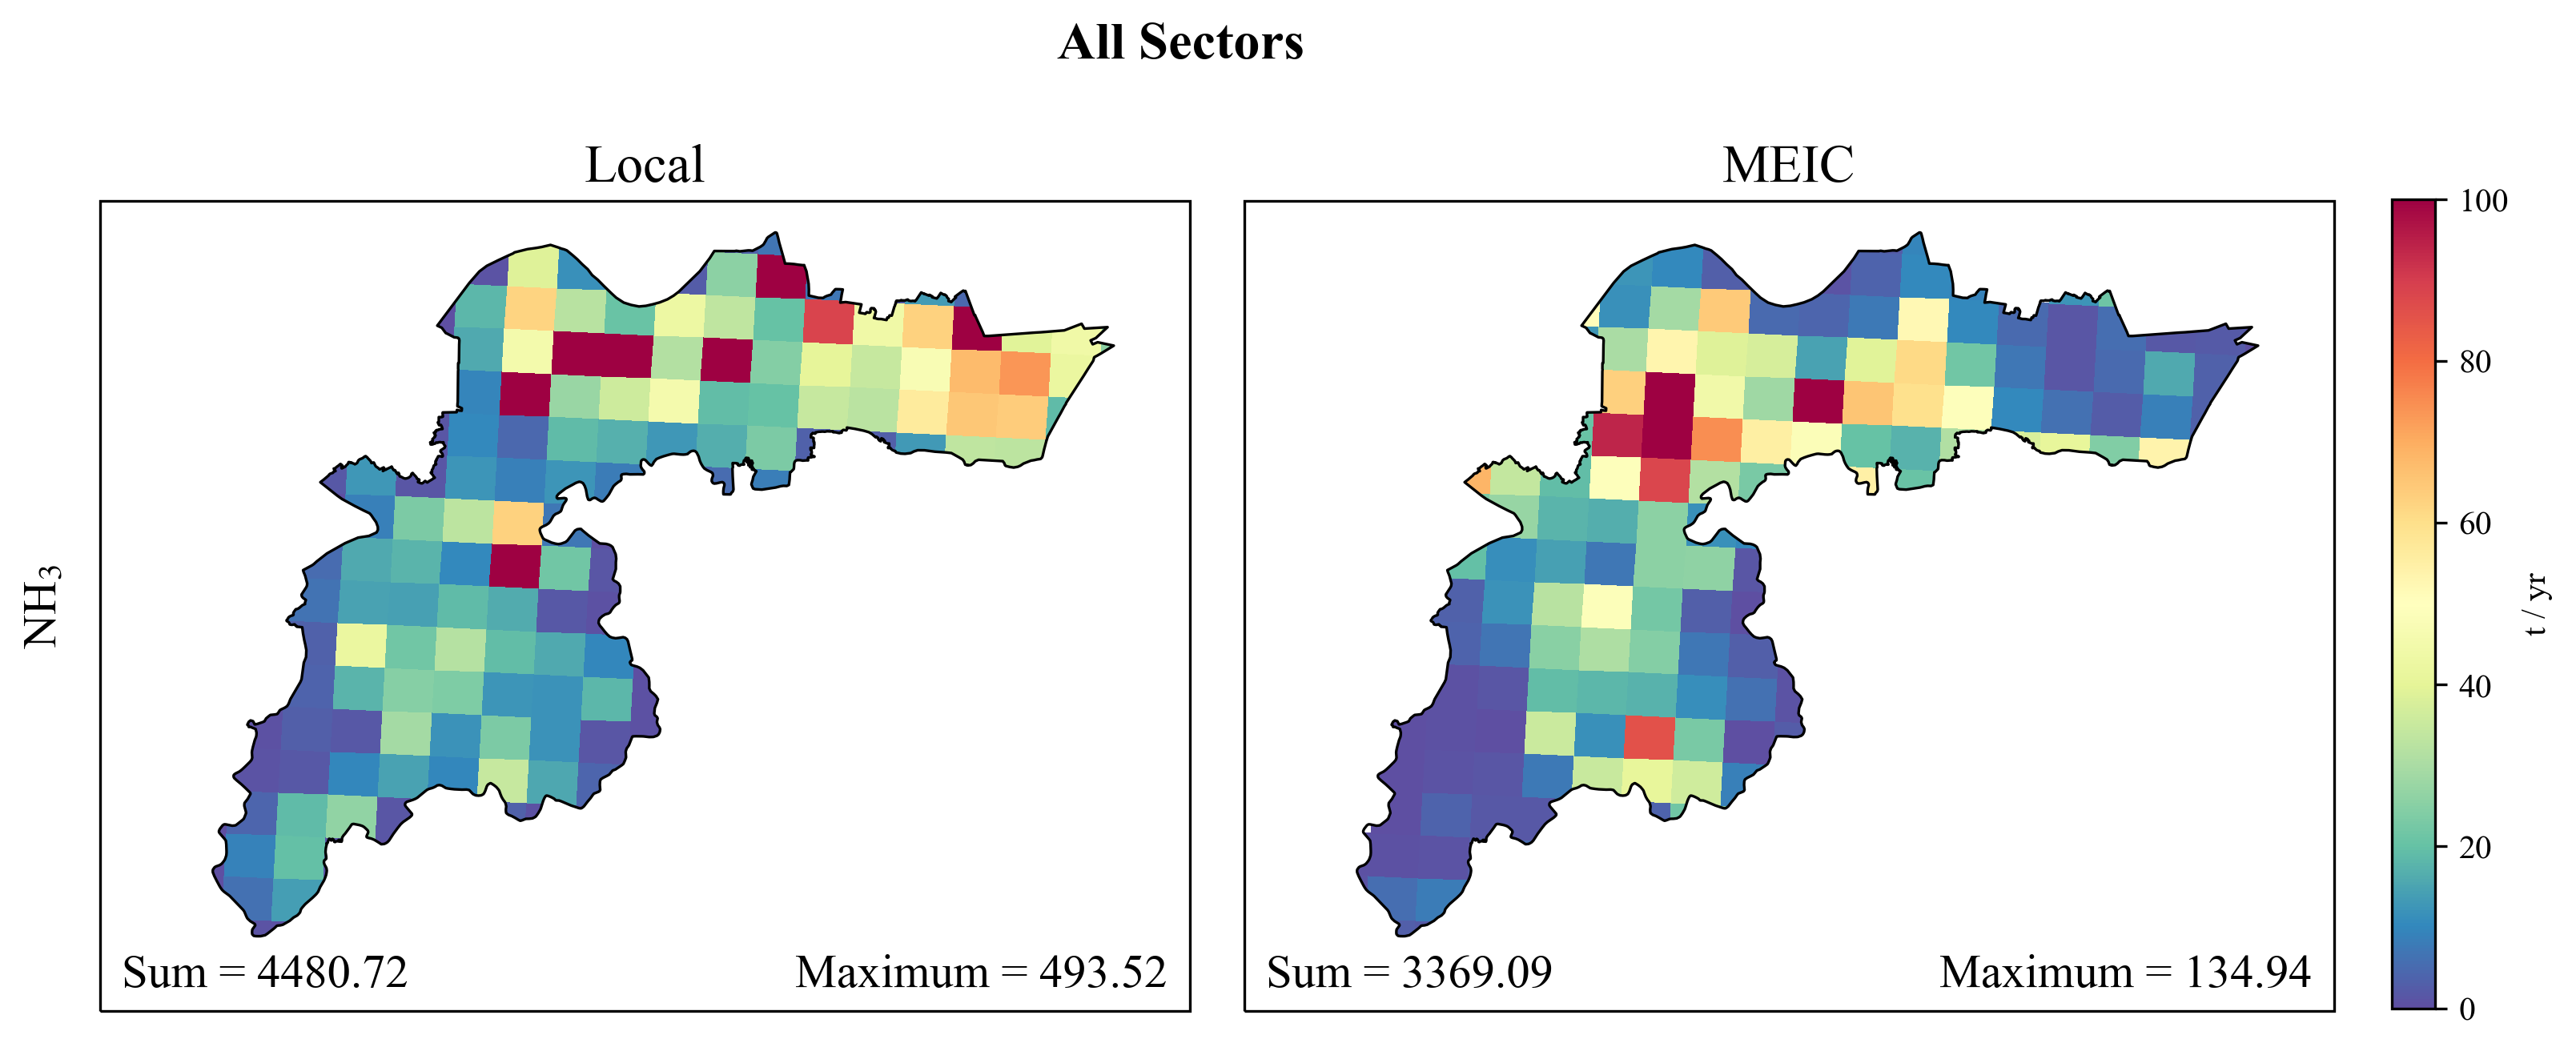

In [9]:
cmin   = 0
cmax   = 100
clevel = 20

# data from local emis
data_local = local.NH3.squeeze()

# data from meic emis
NH3 = meic.NH3.sum(dim='TSTEP').squeeze()
NH3_xs = NH3.where(mask_da)
data_meic = (NH3_xs*17)

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='NH$_3$')

## BC

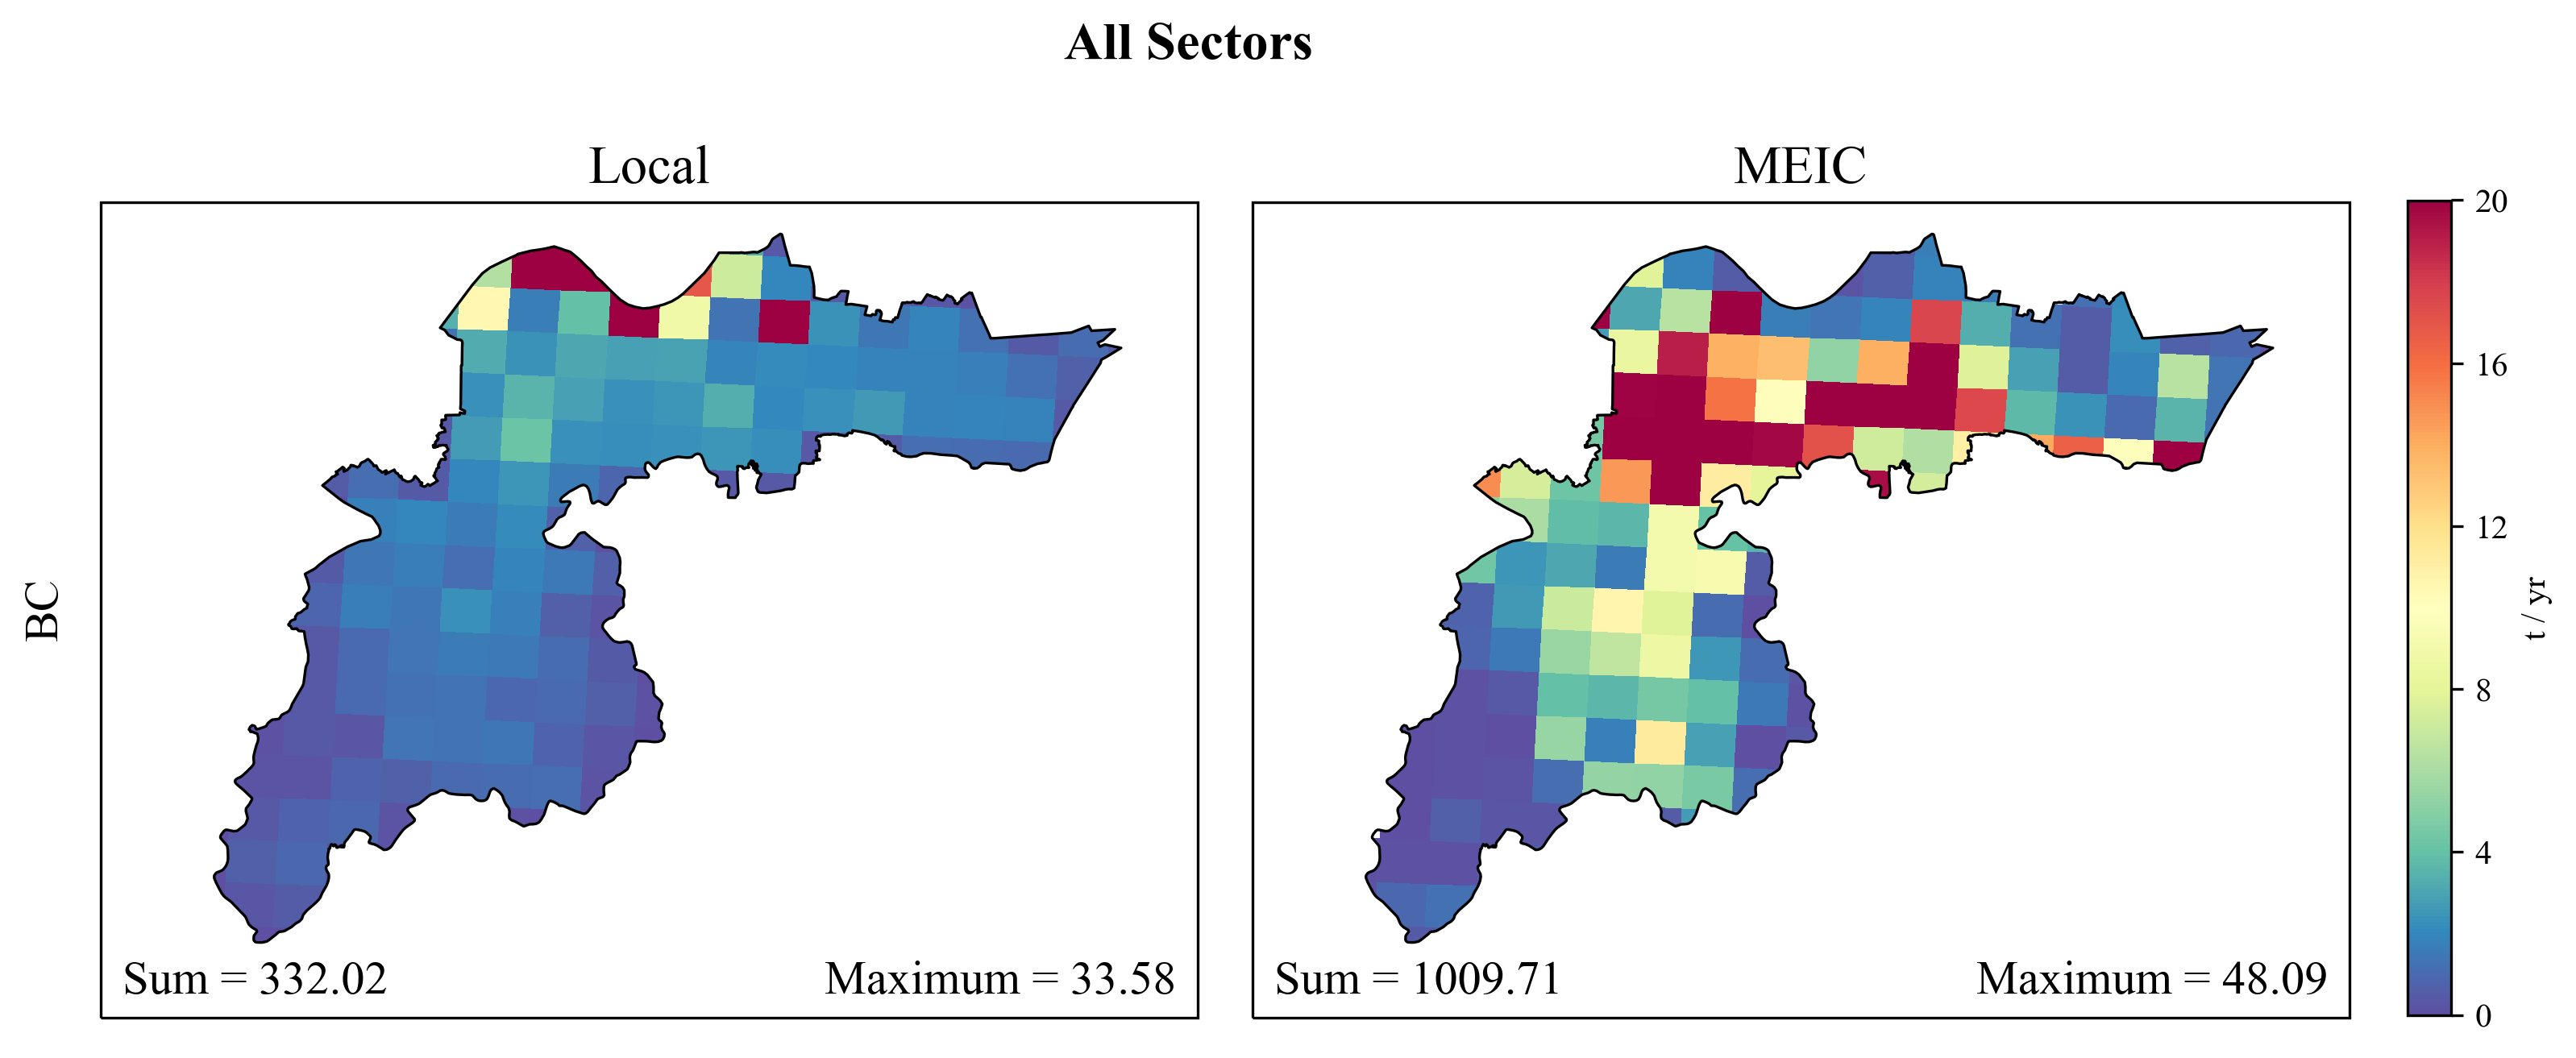

In [23]:
cmin   = 0
cmax   = 20
clevel = 4

# data from local emis
data_local = local.BC.squeeze()

# data from meic emis
PEC = meic.PEC.sum(dim='TSTEP').squeeze()
PEC_xs = PEC.where(mask_da)
data_meic = PEC_xs

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='BC')

## OC

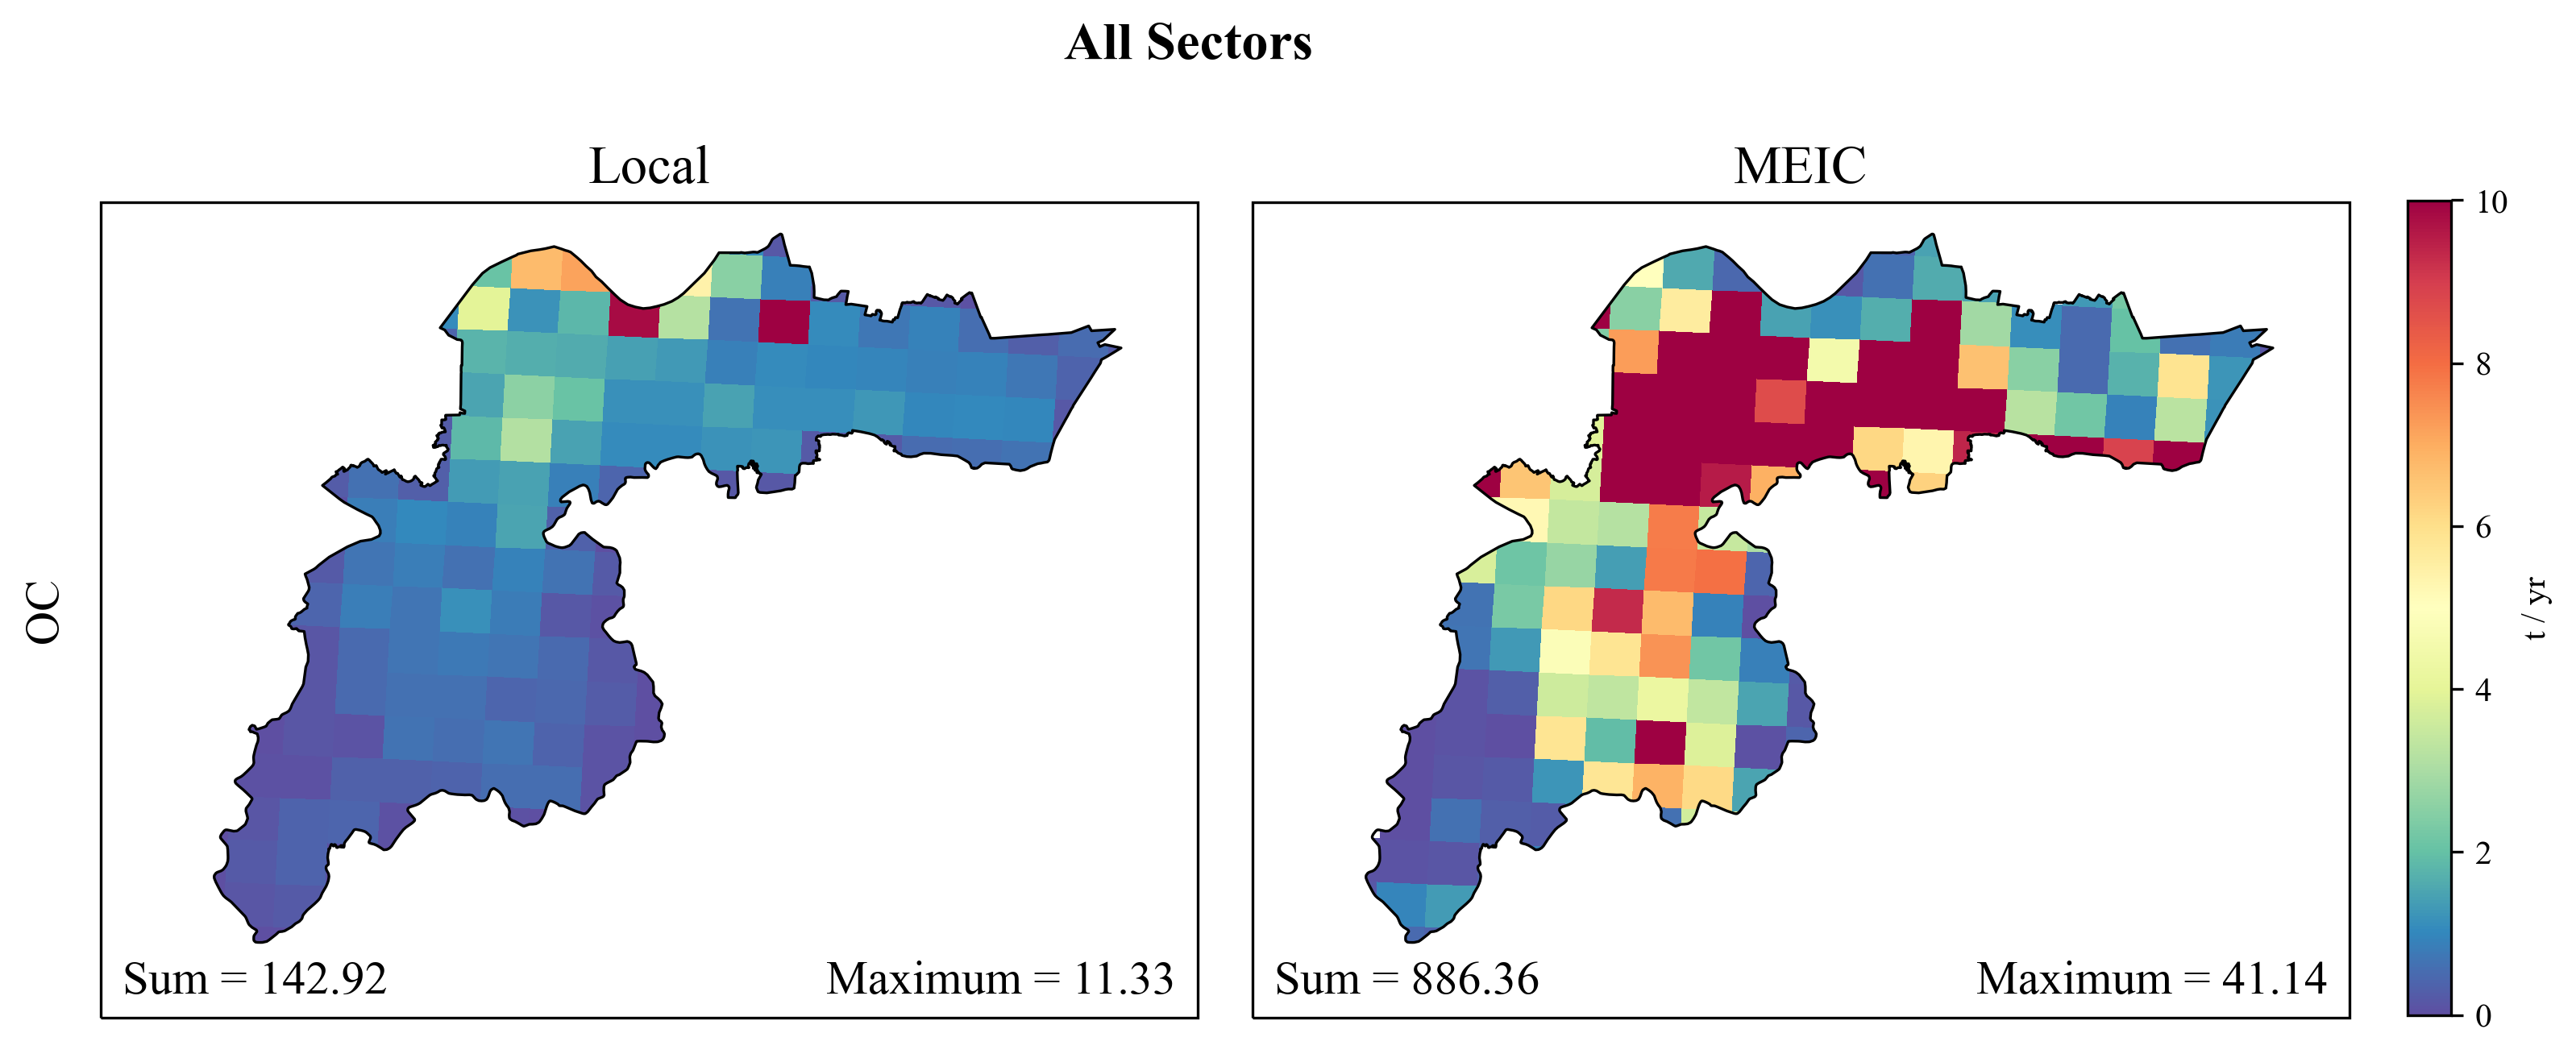

In [34]:
cmin   = 0
cmax   = 10
clevel = 2

# data from local emis
data_local = local.OC.squeeze()

# data from meic emis
POC = meic.POC.sum(dim='TSTEP').squeeze()
POC_xs = POC.where(mask_da)
data_meic = POC_xs

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='OC')

## VOCs

In [7]:
voc_list = pd.read_excel(datadir+'Local_emis_2020/VOC_PM_species.xlsx',sheet_name='VOC')
meic_list = list(meic.variables.keys())

print('If there\'s any specie in excel not found in netcdf?')
for specie in voc_list['species']:
    if specie not in meic_list:
        print(f'{specie} not found')
print('----------------')
print('If there\'s any specie in netcdf not found in excel?')
for specie in meic_list:
    if specie not in list(voc_list['species']):
        print(f'{specie} not found')
        

If there's any specie in excel not found in netcdf?
----------------
If there's any specie in netcdf not found in excel?
TFLAG not found
NO2 not found
NO not found
HONO not found
CO not found
SO2 not found
SULF not found
NH3 not found
PSO4 not found
PNO3 not found
PCL not found
PNH4 not found
PNA not found
PMG not found
PK not found
PCA not found
POC not found
PNCOM not found
PEC not found
PFE not found
PAL not found
PSI not found
PTI not found
PMN not found
PH2O not found
PMOTHR not found
PMC not found
HCL not found
CL2 not found


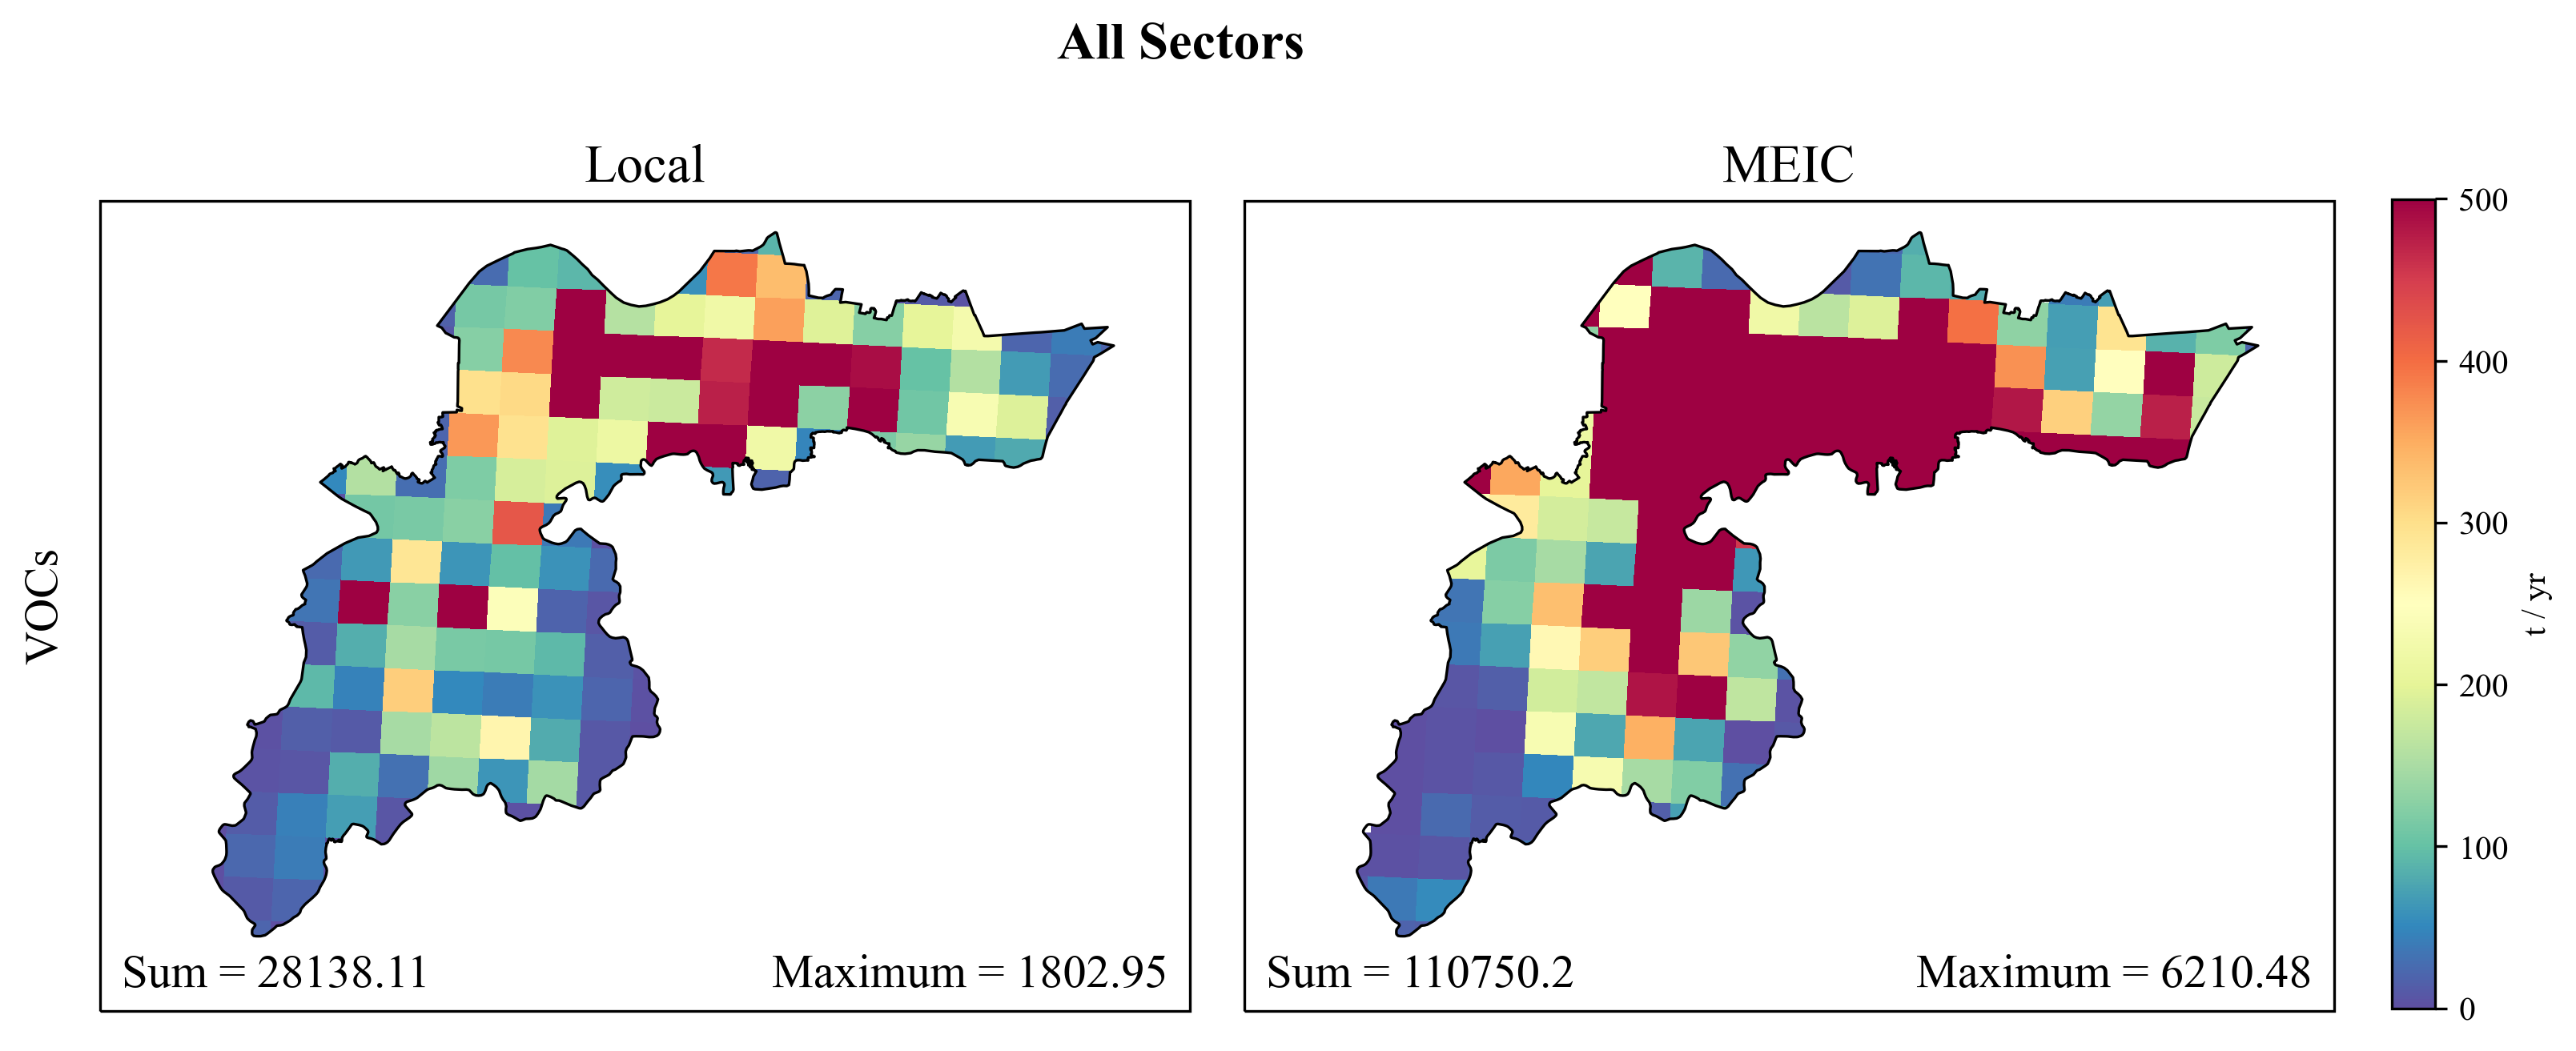

In [8]:
cmin   = 0
cmax   = 500
clevel = 100

# data from local emis
data_local = local.VOCs.squeeze()

# data from meic emis
data_meic = None
for variable_name, variable_moles in zip(list(voc_list['species']),voc_list['moles']):
    variable = getattr(meic, variable_name)
    summed_variable = variable.sum(dim='TSTEP').squeeze()
    masked_variable = summed_variable.where(mask_da)
    if data_meic is None:
        data_meic = masked_variable * variable_moles
    else:
        data_meic += masked_variable * variable_moles

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='VOCs')

## PM25

In [9]:
pm_list = pd.read_excel(datadir+'Local_emis_2020/VOC_PM_species.xlsx',sheet_name='PM25')
meic_list = list(meic.variables.keys())

print('If there\'s any specie in excel not found in netcdf?')
for specie in pm_list['species']:
    if specie not in meic_list:
        print(f'{specie} not found')
print('----------------')
print('If there\'s any specie in netcdf not found in excel?')
for specie in meic_list:
    if specie not in list(pm_list['species']):
        print(f'{specie} not found')
        

If there's any specie in excel not found in netcdf?
----------------
If there's any specie in netcdf not found in excel?
TFLAG not found
NO2 not found
NO not found
HONO not found
CO not found
SO2 not found
SULF not found
NH3 not found
ALK1 not found
ALK2 not found
ALK3 not found
ALK4 not found
ALK5 not found
ETHE not found
PRPE not found
OLE1 not found
OLE2 not found
BDE13 not found
ISOP not found
APIN not found
TERP not found
SESQ not found
BENZ not found
TOLU not found
ARO1 not found
OXYL not found
MXYL not found
PXYL not found
B124 not found
ARO2MN not found
ACYE not found
HCHO not found
CCHO not found
RCHO not found
BALD not found
ACET not found
MEK not found
PRD2 not found
MEOH not found
ETOH not found
FACD not found
AACD not found
PACD not found
GLY not found
MGLY not found
BACL not found
CRES not found
ACRO not found
MACR not found
MVK not found
IPRD not found
RNO3 not found
NAPH not found
SOAALK not found
PMC not found
HCL not found
CL2 not found


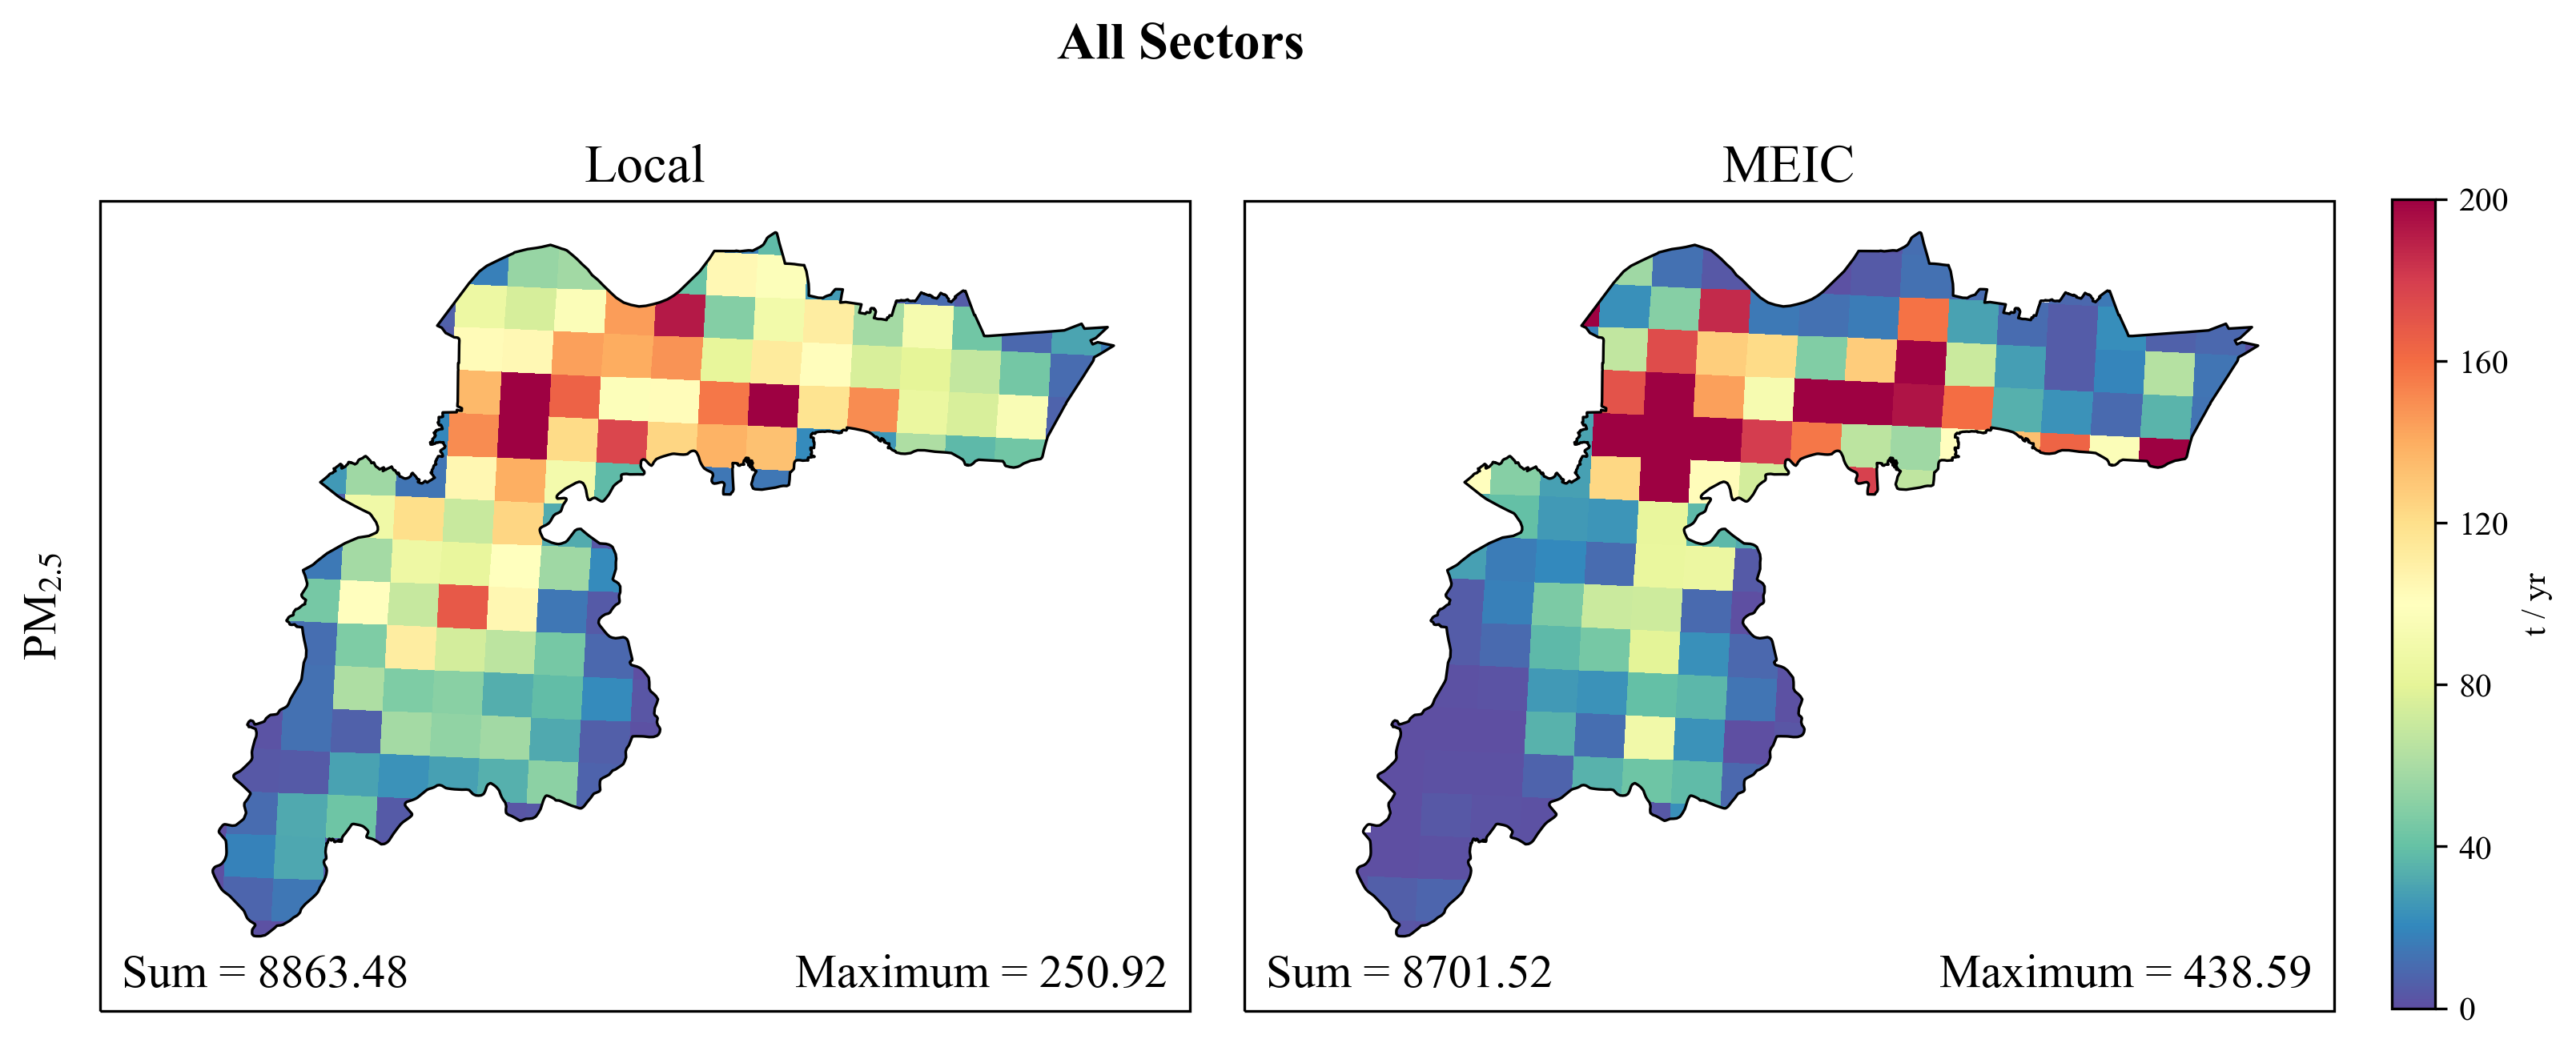

In [11]:
cmin   = 0
cmax   = 200
clevel = 40

# data from local emis
data_local = local.PM25.squeeze()

# data from meic emis
data_meic = None
for variable_name in list(pm_list['species']):
    variable = getattr(meic, variable_name)
    summed_variable = variable.sum(dim='TSTEP').squeeze()
    masked_variable = summed_variable.where(mask_da)
    if data_meic is None:
        data_meic = masked_variable
    else:
        data_meic += masked_variable

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='PM$_{2.5}$')

## PM10

In [12]:
pm_list = pd.read_excel(datadir+'Local_emis_2020/VOC_PM_species.xlsx',sheet_name='PM10')
meic_list = list(meic.variables.keys())

print('If there\'s any specie in excel not found in netcdf?')
for specie in pm_list['species']:
    if specie not in meic_list:
        print(f'{specie} not found')
print('----------------')
print('If there\'s any specie in netcdf not found in excel?')
for specie in meic_list:
    if specie not in list(pm_list['species']):
        print(f'{specie} not found')
        

If there's any specie in excel not found in netcdf?
----------------
If there's any specie in netcdf not found in excel?
TFLAG not found
NO2 not found
NO not found
HONO not found
CO not found
SO2 not found
SULF not found
NH3 not found
ALK1 not found
ALK2 not found
ALK3 not found
ALK4 not found
ALK5 not found
ETHE not found
PRPE not found
OLE1 not found
OLE2 not found
BDE13 not found
ISOP not found
APIN not found
TERP not found
SESQ not found
BENZ not found
TOLU not found
ARO1 not found
OXYL not found
MXYL not found
PXYL not found
B124 not found
ARO2MN not found
ACYE not found
HCHO not found
CCHO not found
RCHO not found
BALD not found
ACET not found
MEK not found
PRD2 not found
MEOH not found
ETOH not found
FACD not found
AACD not found
PACD not found
GLY not found
MGLY not found
BACL not found
CRES not found
ACRO not found
MACR not found
MVK not found
IPRD not found
RNO3 not found
NAPH not found
SOAALK not found
HCL not found
CL2 not found


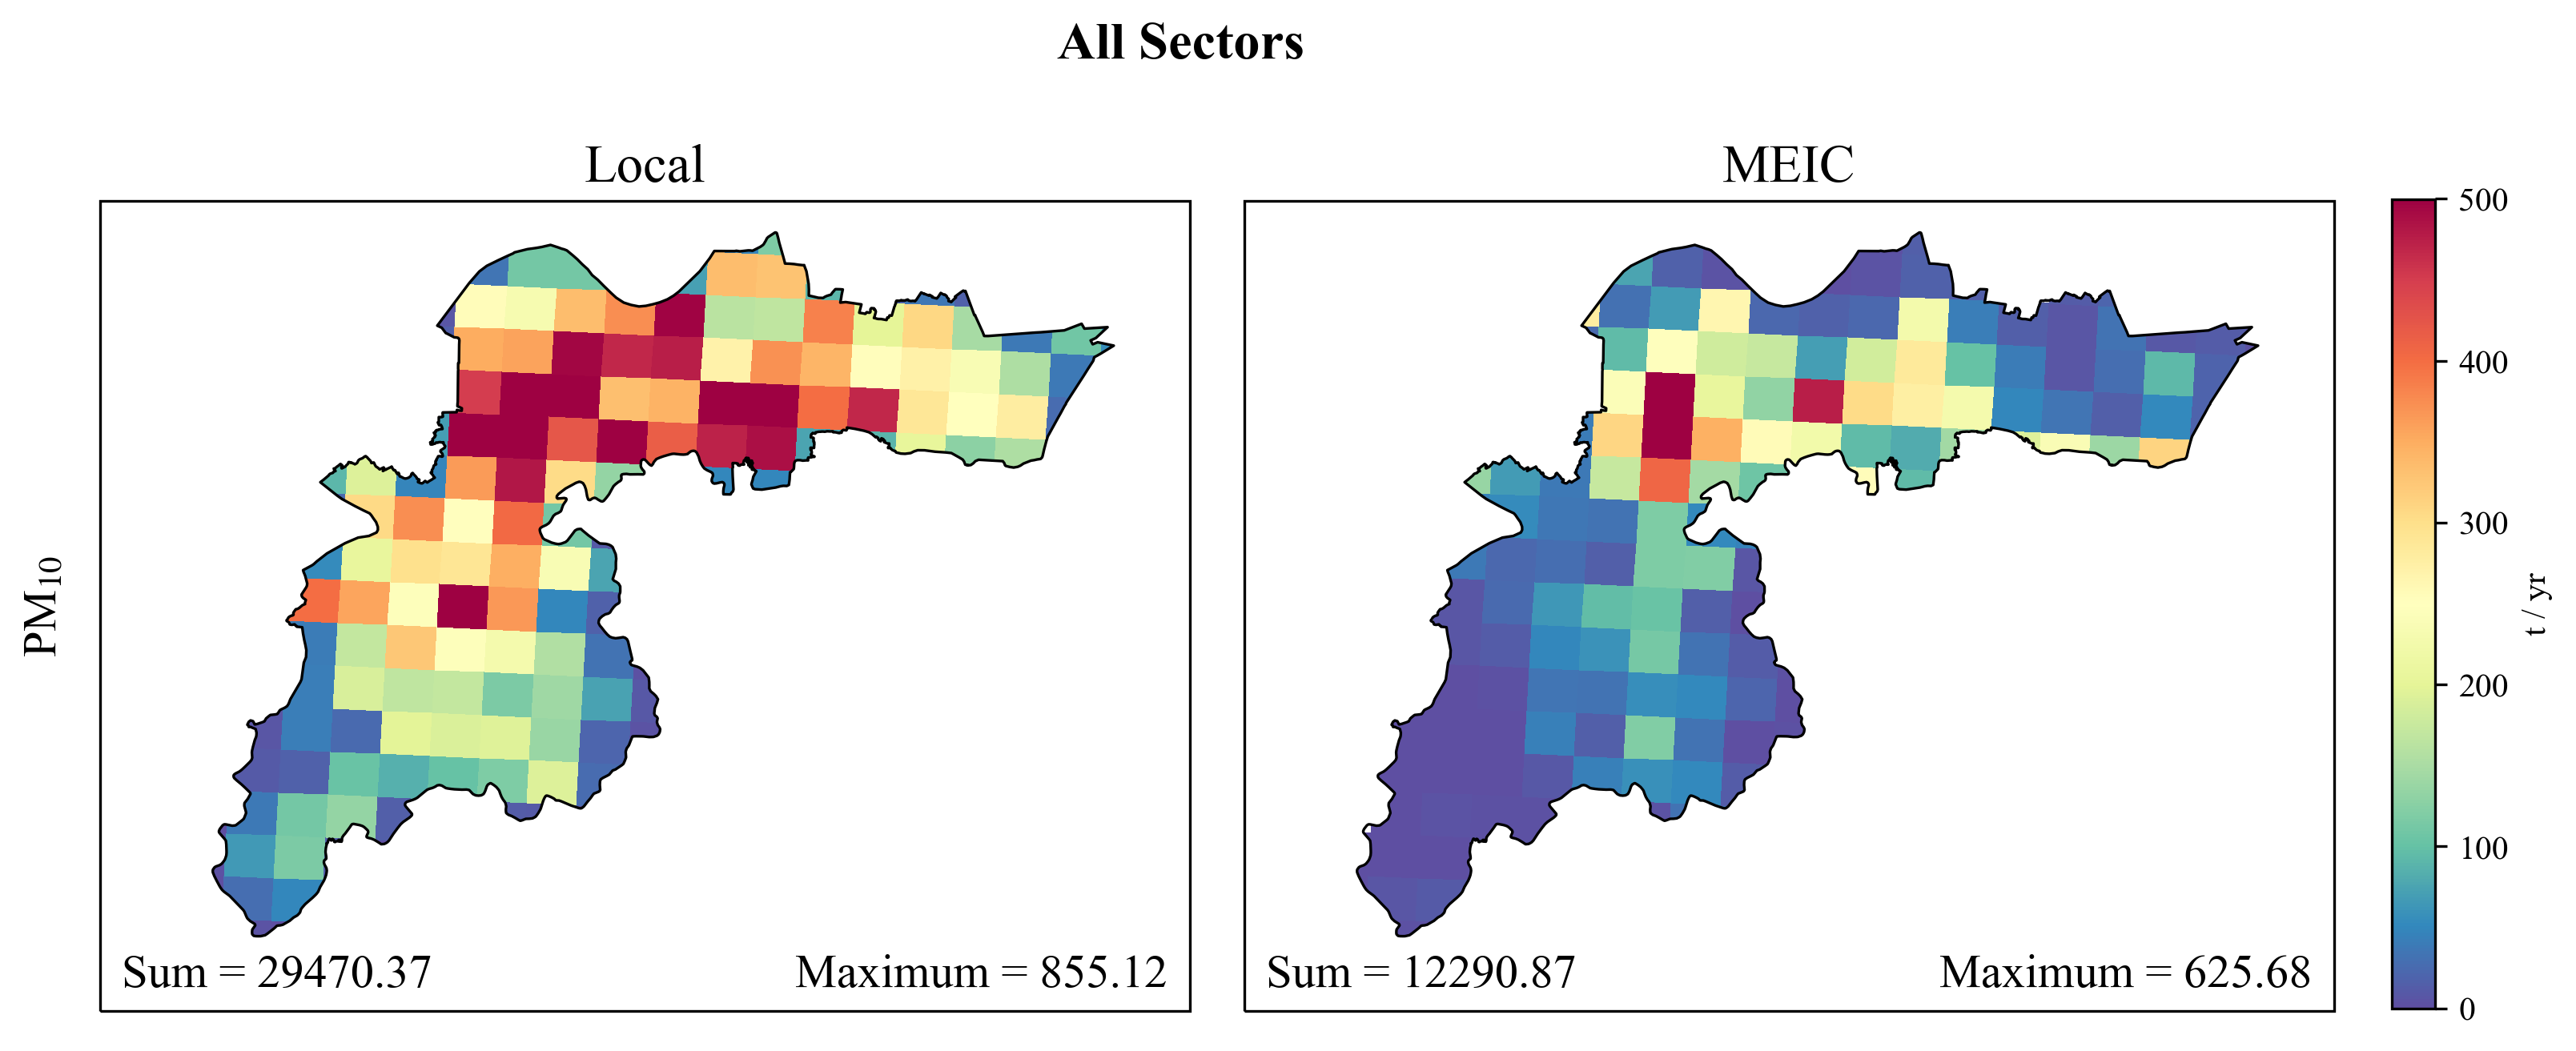

In [14]:
cmin   = 0
cmax   = 500
clevel = 100

# data from local emis
data_local = local.PM10.squeeze()

# data from meic emis
data_meic = None
for variable_name in list(pm_list['species']):
    variable = getattr(meic, variable_name)
    summed_variable = variable.sum(dim='TSTEP').squeeze()
    masked_variable = summed_variable.where(mask_da)
    if data_meic is None:
        data_meic = masked_variable
    else:
        data_meic += masked_variable

double_pcolor(lon,lat,data_local,data_meic,cmin,cmax,
           map_polygon=xiaoshan,mask_polygon=xiaoshan,
           extent=using_extent,colorlevel=clevel,
           sectionname=using_sec,varstring='PM$_{10}$')